# Introduction

In this article, I'll try to show you a few examples of Meta Prophet usage and some tweaks to improve the quality of the model, especially if it obtains a low score with standard parameters.

In general, Prophet is a free library with R and Python APIs. The tool is fairly easy to use for those familiar with the Pandas and NumPy libraries and the complete basics of machine learning.

In summary, this paper requires some knowledge in machine learning, however, thanks to Prophet's intuitive interface and advanced features, it can be used by individuals who do not possess specialized knowledge in this field. The length of the article should not be a concern, as a significant portion is dedicated to clear and informative graphs that allow for quick and easy understanding of the analyzed data. With this tool, forecasting trends and behaviors based on data becomes simpler and more intuitive.

# 1. Daily number of posts on medium.com website

[This dataset](https://www.kaggle.com/datasets/kashnitsky/mlcourse?select=medium_posts.csv) contains the dates of posts published on medium.com. We can sum the daily number of posts and try to forecast future values.

## Load the data

In [63]:
from common import *

df = pd.read_csv('medium_posts.csv')
df['published_date'] = pd.to_datetime(df['published']).dt.date
df = df.drop(columns='published')

df_by_day = df['published_date'].value_counts().sort_index() # sum articles for each year
df_by_day = df_by_day.to_frame().reset_index()
df_by_day.rename(columns={"published_date": "y", "index": "ds"}, inplace=True) # rename columns using Prophet's convention
print("First five rows:")
df_by_day.head()

First five rows:


,ds,y
0,1970-01-01,2
1,1970-01-18,3
2,2003-09-14,1
3,2004-04-04,1
4,2004-04-16,1


Two rows are from 1970 - it's probably an error. Let's remove them and plot the data:

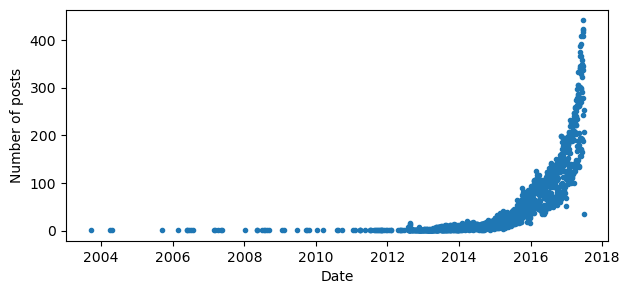

In [64]:
df_by_day = df_by_day.iloc[2:]
plt.figure(figsize=(7,3))
plt.plot(df_by_day['ds'], df_by_day['y'], '.')
plt.xlabel("Date")
plt.ylabel("Number of posts");

Until 2013 there are a lot of dates without number of posts. In these years Medium was probably very small website and using that thata can lead to unreliable predictions. I'll cut all rows to 01-01-2013.

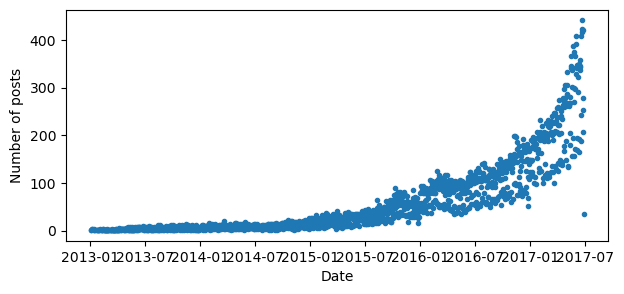

In [65]:
cut_date = datetime.date(2013, 1, 1)
df_by_day = df_by_day[df_by_day.ds > cut_date]
plt.figure(figsize=(7,3))
plt.plot(df_by_day['ds'], df_by_day['y'], '.')
plt.xlabel("Date")
plt.ylabel("Number of posts");

# Prediction for standard parameters, forecast components:

The next paragraph of the article describes a code snippet that initializes a Prophet model, fits data from the previous cell, and generates a one-year forecast. It's almost the simplest case. There is one tweak: the growth type is specified as 'logistic', which often works better for data with non-linear (for example - exponential) growth. With this parameter, we need to set the maximum value. Optionally, we can specify a minimum value. By default, floor is specified as 0, so in this case I don't need to write it myself.

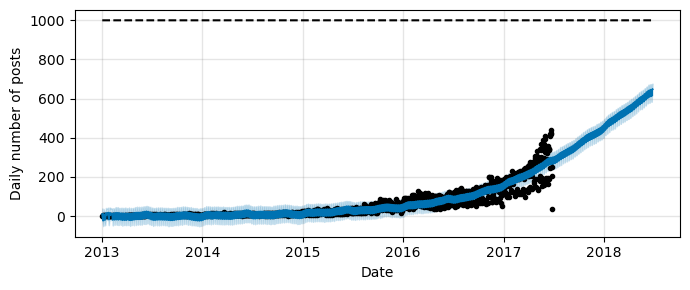

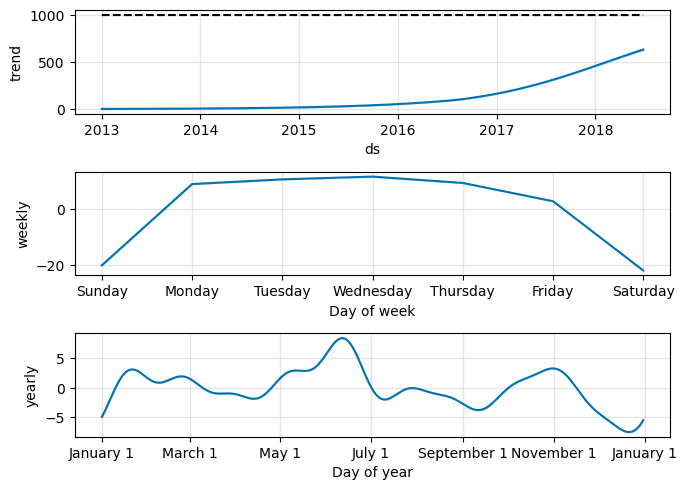

In [49]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
m = Prophet(growth='logistic')
df_by_day['cap'] = 1000
m.fit(df_by_day)
future = m.make_future_dataframe(periods=365)
future['cap'] = 1000
forecast = m.predict(future)
fig1 = m.plot(forecast, figsize=(7, 3), xlabel='Date', ylabel='Daily number of posts')
fig2 = m.plot_components(forecast, figsize=(7, 5))

The last three plots show trends and seasonalities.

Trend refers to the long-term pattern or direction of the data, which can be increasing, decreasing, or stable over time. It can also have [changepoints](https://facebook.github.io/prophet/docs/trend_changepoints.html). In Prophet, the trend is modeled with a regression function.

Seasonality, on the other hand, refers to the repetitive patterns or cycles that occur over a period of time. For example, sales of ice cream may show a peak in the summer months and a trough in the winter months, while website traffic may exhibit higher levels on weekdays than on weekends. In Prophet, seasonality is modeled with Fourier series, a mathematical technique that decomposes a periodic signal into a sum of sine and cosine waves with different frequencies, amplitudes, and phases.

In these plots, we see a trend, probably with exponential growth, and two types of seasonalities. Users publish fewer posts on Saturday and Sunday, in addition to the fact that activity varies throughout the year.

# Cross validation, metrics

Cross validation is an important step in evaluating the performance of Prophet models. In cross validation, the historical data is split into multiple segments, and the model is trained on one segment and tested on the others. This process is repeated multiple times to obtain an average measure of performance. Cross validation helps to assess the model's ability to generalize to new data and can provide insight into how the model may perform in the future.

In this example, the starting segment will consist of first 730 days ("initial") of the dataset, which will be used for training the model. The next 365 days ("horizon") will be used as a test set to evaluate the model's performance. After that, 182 days ("period") will be added to both the start and end of these ranges, creating the next train and test segments. This process will be repeated until the dataset is too small for the next iteration.

  0%|          | 0/3 [00:00<?, ?it/s]

Mean MAE: 25.719122798589403
Mean MAPE: 29.287699249711096 %


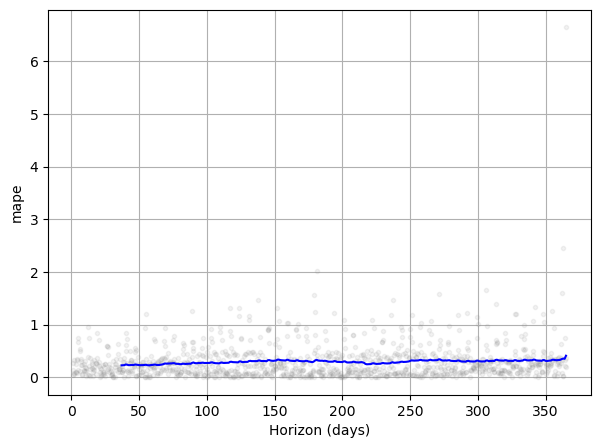

In [51]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)
df_cv = cross_validation(m, initial='730 days', period='182 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
print("Mean MAE:", str(df_p['mae'].mean()))
print("Mean MAPE:", str(df_p['mape'].mean() * 100), '%')
fig = plot_cross_validation_metric(df_cv, metric='mape', figsize=(7, 5))

What are these values and the plot in the cell above? The first two numbers show how well the model performed on the test data during cross-validation.

MAE (Mean Absolute Error) measures the average absolute difference between predicted and actual values. It is calculated by taking the average of the absolute differences between predicted and actual values for each data point.

MAPE (Mean Absolute Percentage Error) measures the average absolute percentage difference between predicted and actual values. It is calculated by taking the average of the absolute percentage differences between the predicted and actual values for each data point. MAPE provides information about the magnitude of the errors relative to the actual values. MAPE is useful when the scale of the data varies significantly, as it takes into account the relative size of the errors.

The plot above shows how the MAPE varies with the prediction horizon.

Now let's look at a specific forecast for all cross-validation splits and later for a single year.

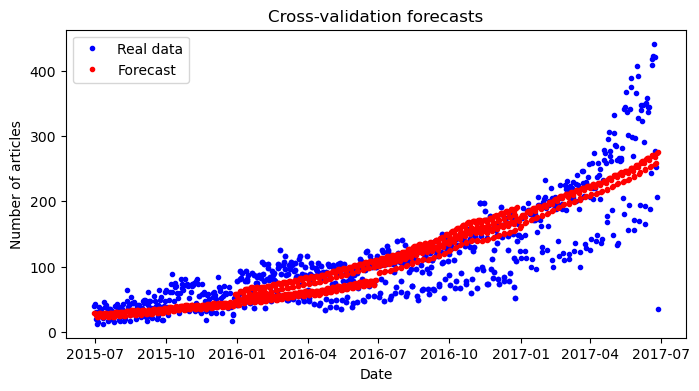

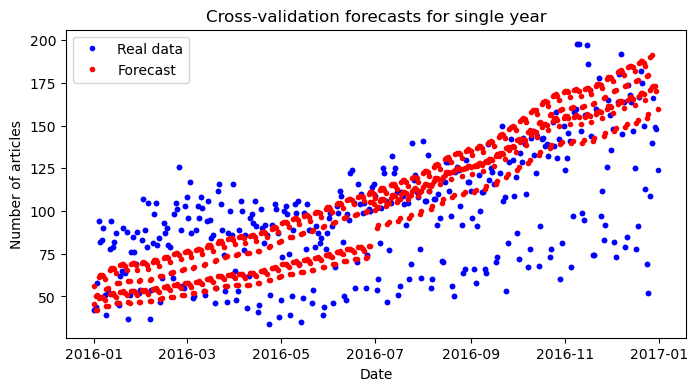

In [41]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df_cv['ds'], df_cv['y'], 'b.', label='Real data')
ax.plot(df_cv['ds'], df_cv['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Number of articles')
ax.legend(loc='upper left')
ax.set_title('Cross-validation forecasts')

plt.show()

lower_date = np.datetime64('2016-01-01')
upper_date = np.datetime64('2017-01-01')
year_forecast = df_cv[(df_cv.ds >= lower_date) & (df_cv.ds < upper_date)]


fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(year_forecast['ds'], year_forecast['y'], 'b.', label='Real data')
ax.plot(year_forecast['ds'], year_forecast['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Number of articles')
ax.legend(loc='upper left')
ax.set_title('Cross-validation forecasts for single year')

plt.show()

As you can see, the model can detect the general trend, but it has problems in determining the values more accurately. If these fluctuations are not completely random, we should be able to provide better results.

# Hyperparameters tuning

TODO: very short note about tuning

In [8]:
import warnings
warnings.filterwarnings("ignore")

tune_optuna_logistic(df_by_day, 1000, save_study_name="medium-study-logistic-mape-shorter-cut", metric='mape')

[I 2023-03-12 12:08:40,182] A new study created in RDB with name: medium-study-logistic-mape-shorter-cut


Best trial:
   mape :  0.16693401279454115
  Params: 
    changepoint_prior_scale: 0.3758001747787103
    changepoint_range: 0.9318725689779309
    holidays_prior_scale: 0.017984952317648
    seasonality_mode: multiplicative
    seasonality_prior_scale: 0.029518181474767858


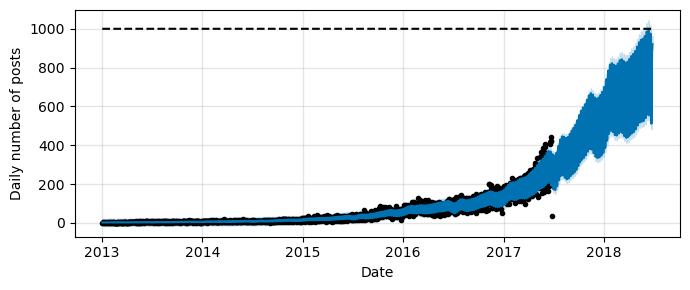

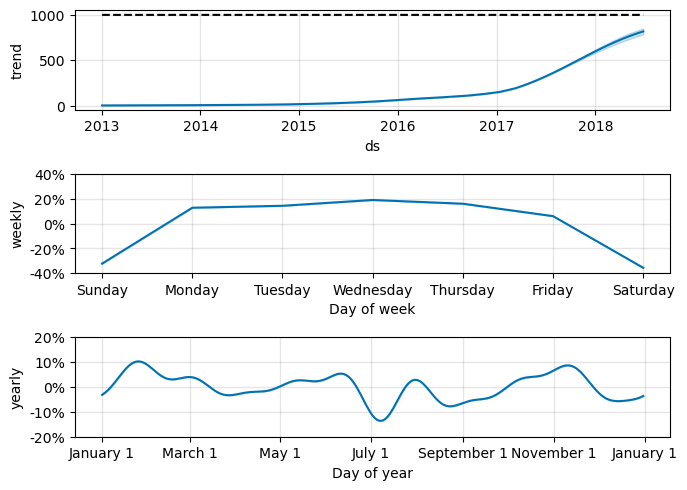

In [42]:
m = Prophet(changepoint_prior_scale=0.3758001747787103, changepoint_range=0.9318725689779309,
           holidays_prior_scale=0.017984952317648, seasonality_mode='multiplicative',
           seasonality_prior_scale=0.029518181474767858, growth='logistic')
m.fit(df_by_day)
future = m.make_future_dataframe(periods=365)
future['cap'] = 1000
forecast = m.predict(future)
fig1 = m.plot(forecast, figsize=(7, 3), xlabel='Date', ylabel='Daily number of posts')
fig2 = m.plot_components(forecast, figsize=(7, 5))

  0%|          | 0/3 [00:00<?, ?it/s]

Mean MAE: 18.458596128416353
Mean MAPE: 15.99771517901695 %


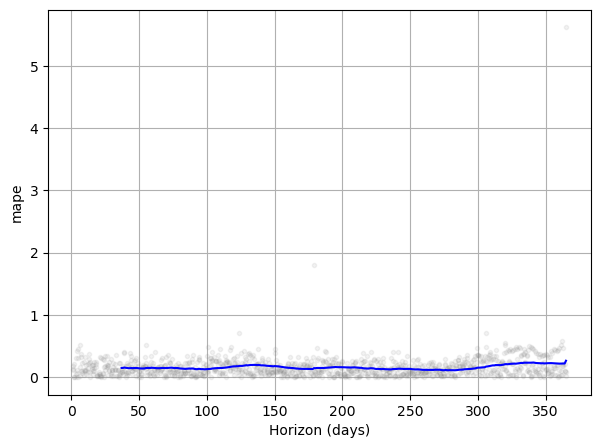

In [43]:
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)
df_cv = cross_validation(m, initial='730 days', period='182 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
print("Mean MAE:", str(df_p['mae'].mean()))
print("Mean MAPE:", str(df_p['mape'].mean()*100), '%')
fig = plot_cross_validation_metric(df_cv, metric='mape', figsize=(7, 5))

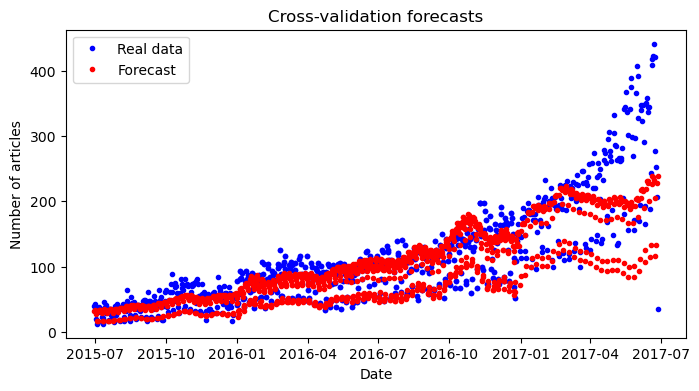

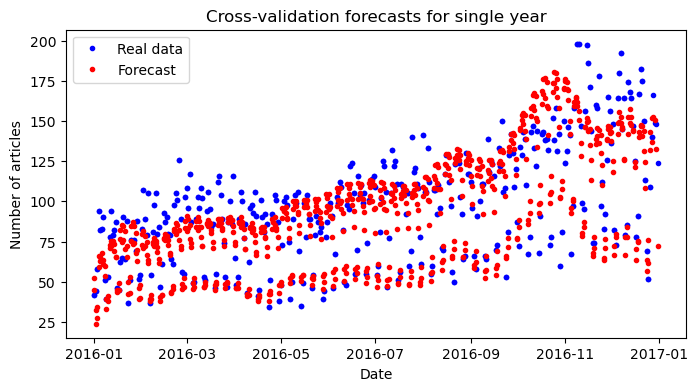

In [44]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df_cv['ds'], df_cv['y'], 'b.', label='Real data')
ax.plot(df_cv['ds'], df_cv['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Number of articles')
ax.legend(loc='upper left')
ax.set_title('Cross-validation forecasts')
plt.show()

lower_date = np.datetime64('2016-01-01')
upper_date = np.datetime64('2017-01-01')
year_forecast = df_cv[(df_cv.ds >= lower_date) & (df_cv.ds < upper_date)]

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(year_forecast['ds'], year_forecast['y'], 'b.', label='Real data')
ax.plot(year_forecast['ds'], year_forecast['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Number of articles')
ax.set_title('Cross-validation forecasts for single year')
ax.legend(loc='upper left')

plt.show()

TODO: summary about tuned model

# 2. Forecasting the hourly number of ads

TODO: add note and source
https://www.kaggle.com/datasets/kashnitsky/mlcourse?select=ads.csv

## Load the data, first simple model

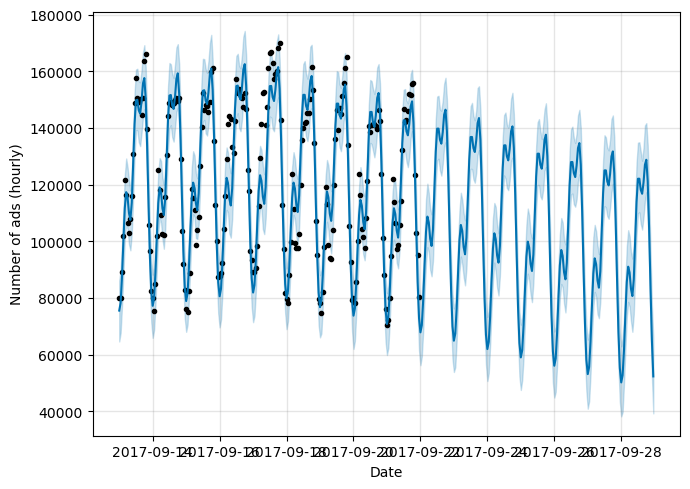

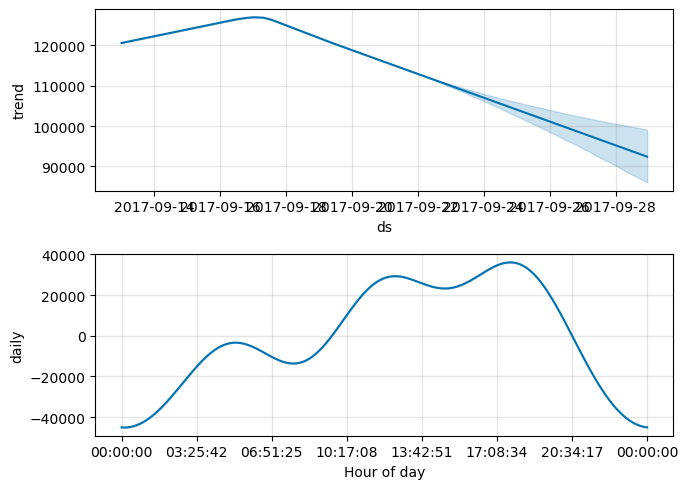

In [54]:
df = pd.read_csv('ads.csv')
df.rename(columns={"Time":"ds", "Ads":"y"}, inplace=True)

m = Prophet()
m.fit(df)

future = m.make_future_dataframe(periods=24*7, freq='H')
forecast = m.predict(future)

fig1 = m.plot(forecast, xlabel="Date", ylabel="Number of ads (hourly)", figsize=(7, 5))
fig2 = m.plot_components(forecast, figsize=(7, 5))

Calculate MAPE score and plot cross-validation forecasts:

Mean MAPE:  0.06944672897219573


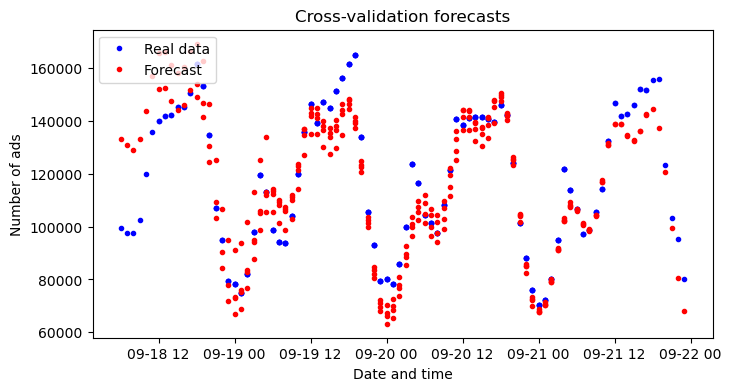

In [56]:
df_cv = cross_validation(m, initial='5 days', period='6 hours', horizon = '24 hours', parallel="processes")
df_p = performance_metrics(df_cv)
print("Mean MAPE: ", str(df_p['mape'].mean()))

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df_cv['ds'], df_cv['y'], 'b.', label='Real data')
ax.plot(df_cv['ds'], df_cv['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date and time')
ax.set_ylabel('Number of ads')
ax.legend(loc='upper left')
ax.set_title('Cross-validation forecasts')
plt.show()

## Tune model and compare results

In [12]:
tune_optuna(df, save_study_name='ads', metric="mape", initial='5 days', period='6 hours', horizon='24 hours')

/home/jsowa/work/prophet/common.py:83: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial({
/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/site-packages/optuna/study/study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/site-packages/optuna/study/study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(


Best trial:
   mape :  0.06087658873860407
  Params: 
    changepoint_prior_scale: 0.035033218143421044
    changepoint_range: 0.8548855487747484
    holidays_prior_scale: 4.158901360548356
    seasonality_mode: additive
    seasonality_prior_scale: 0.029310502345129764


Predictions are more accurate by about 0.9 percentage points. To be honest, it's not enough to see it at a glance.

# 3. Bike sharing demand dataset

[This dataset](https://www.kaggle.com/c/bike-sharing-demand) contains information about how many people rented a bike at a given hour. It's a nice example to show how additional features associated with the target can be used in Prophet for forecasting.


## Load the data, train first simple model

TODO: add mean MAE of first model

In [57]:
from common import *

df = pd.read_csv('bike_demand.csv')
df.rename(columns={"datetime":"ds", "count":"y"}, inplace=True)
df.head()

,ds,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,y
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Let's train the simplest model - with standard parameters.

16:38:45 - cmdstanpy - INFO - Chain [1] start processing
16:38:53 - cmdstanpy - INFO - Chain [1] done processing


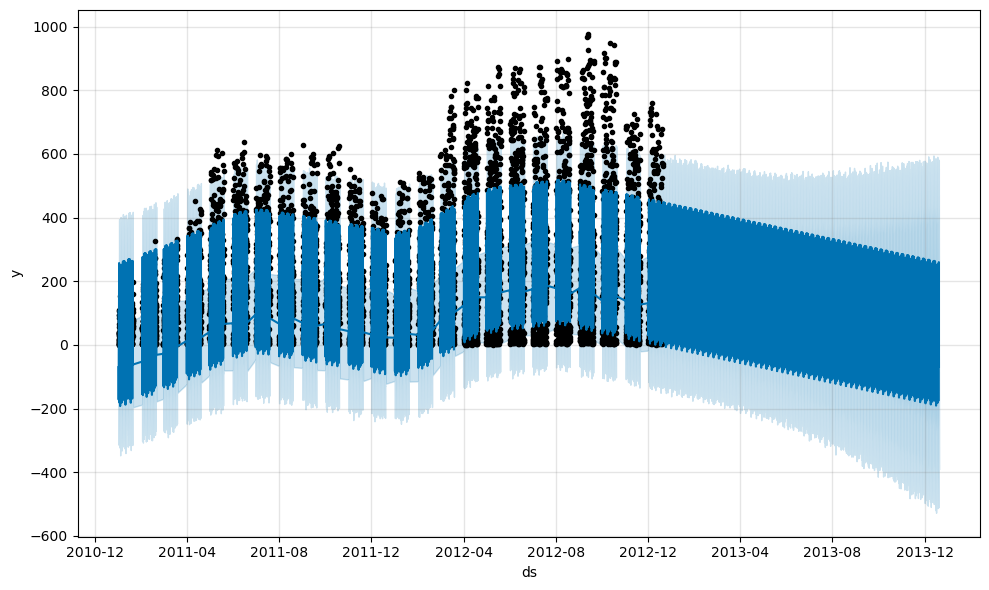

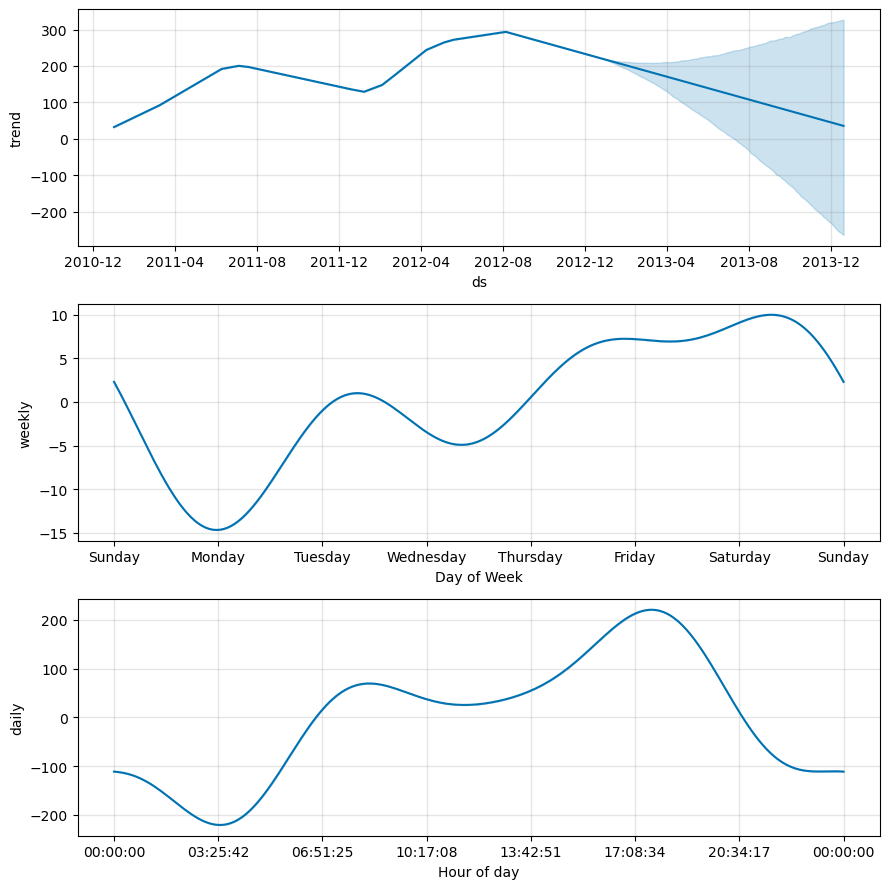

In [3]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=24*365, freq='H')
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

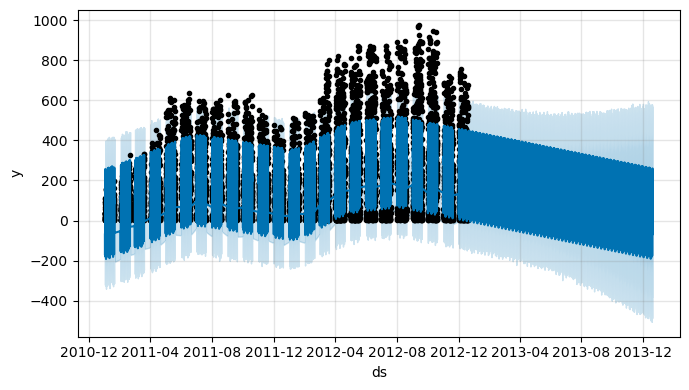

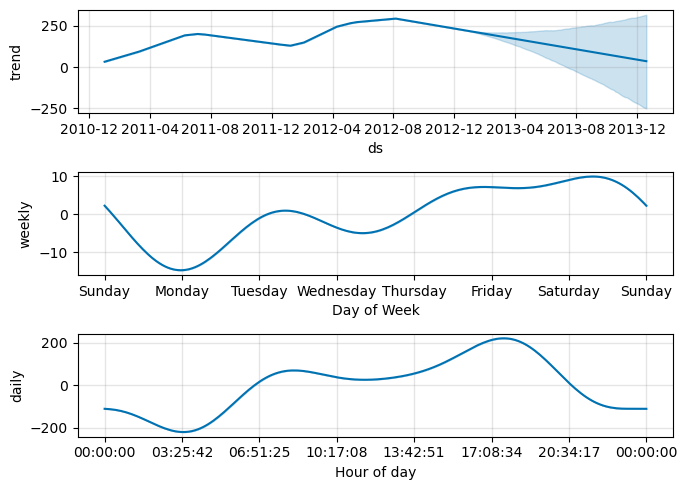

In [60]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=24*365, freq='H')
forecast = m.predict(future)
fig1 = m.plot(forecast, figsize=(7, 4))
fig2 = m.plot_components(forecast, figsize=(7, 5))

## Add yeatly seasonality

What's wrong with this forecast? By default, Prophet looks for yearly seasonality only if there are two full years of data. This kind of information is very important in this model. People, for example, ride their bikes less frequently in the winter than they do in the summer. I'll try to add it manually:

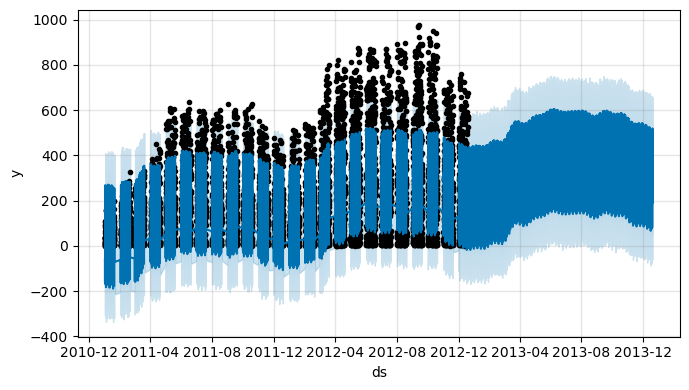

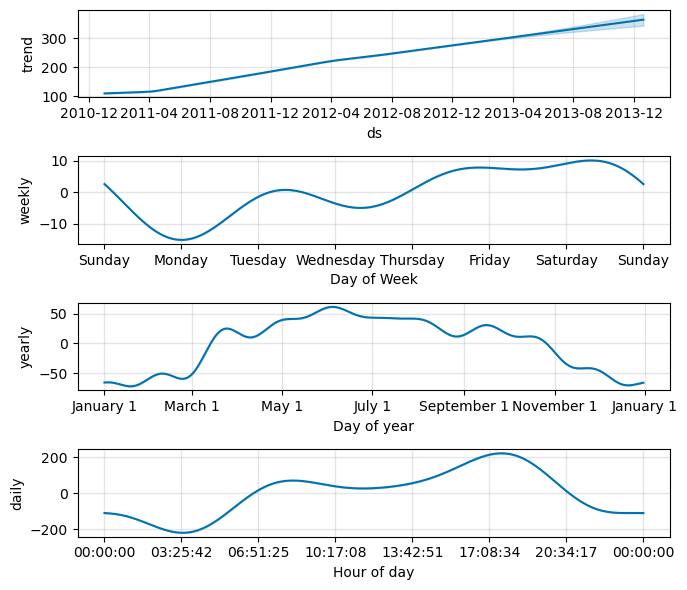

In [62]:
m = Prophet()
m.add_seasonality(name='yearly', period=365, fourier_order=10)
m.fit(df)
future = m.make_future_dataframe(periods=24*365, freq='H')
forecast = m.predict(future)
fig1 = m.plot(forecast, figsize=(7, 4))
fig2 = m.plot_components(forecast, figsize=(7, 6))

Now the trend looks completely different, and the forecast for next year looks more reliable.

TODO: remove plots, but leave metric?

Mean MAE:  102.04763012417447


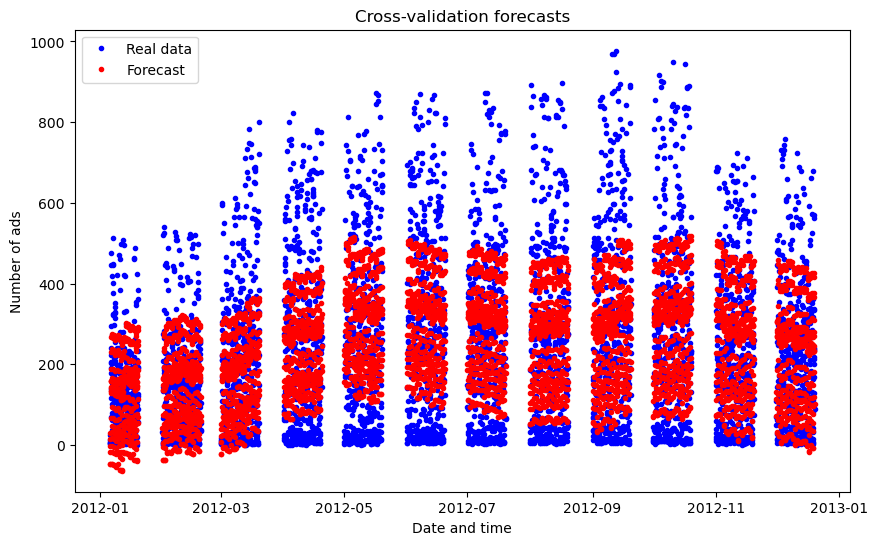

In [16]:
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
df_p = performance_metrics(df_cv)
print("Mean MAE: ", str(df_p['mae'].mean()))

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_cv['ds'], df_cv['y'], 'b.', label='Real data')
ax.plot(df_cv['ds'], df_cv['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date and time')
ax.set_ylabel('Number of ads')
ax.legend(loc='upper left')
ax.set_title('Cross-validation forecasts')
plt.show()

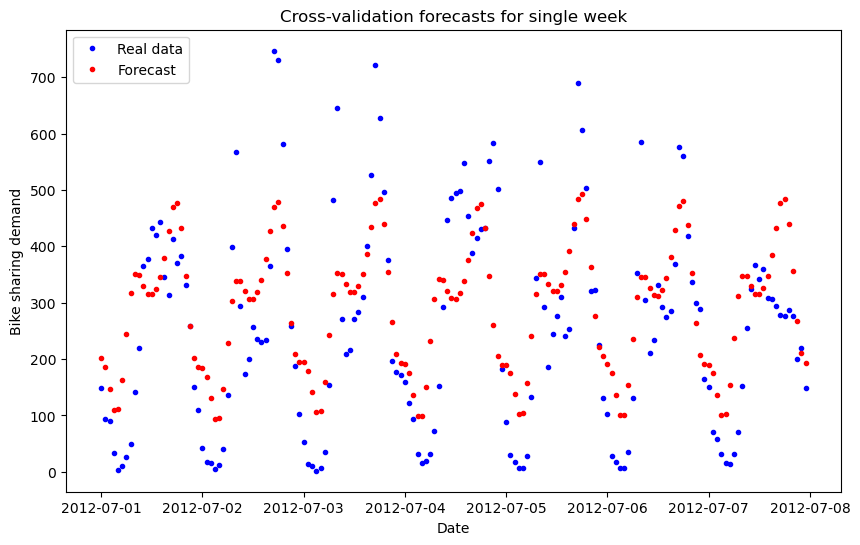

In [17]:
lower_date = np.datetime64('2012-07-01')
upper_date = np.datetime64('2012-07-08')
week_forecast = df_cv[(df_cv.ds >= lower_date) & (df_cv.ds < upper_date)]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(week_forecast['ds'], week_forecast['y'], 'b.', label='Real data')
ax.plot(week_forecast['ds'], week_forecast['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Bike sharing demand')
ax.set_title('Cross-validation forecasts for single week')
ax.legend(loc='upper left')

plt.show()

## Add the minimum prediction value by using the logarithmic and exponential functions

What's the next issue? Some of the forecast predictions are... below zero! We know that it's completely irrational - it is not possible for a negative number of bicycles to be rented.

I'll show you one way to fix it. We can first logarithmize the values before fitting them and then apply an exponential function to them. The value of the exponential function is always positive, so the final targets will also be positive.

Mean MAE: 87.99573783891074


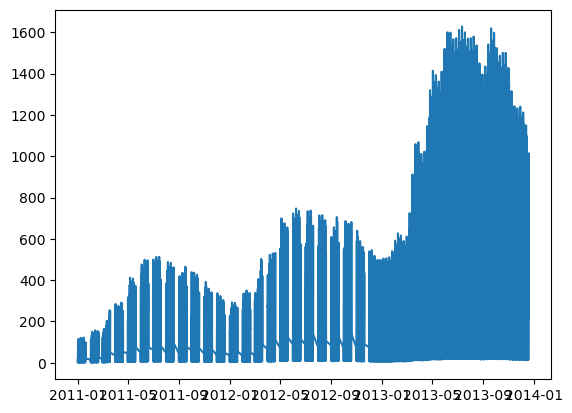

In [13]:
from common import *

df = pd.read_csv('bike_demand.csv')
df.rename(columns={"datetime":"ds", "count":"real_y"}, inplace=True)
df["y"] = np.log(df["real_y"])

m = Prophet()
m.add_seasonality(name='yearly', period=365, fourier_order=10)
m.fit(df)
future = m.make_future_dataframe(periods=24*365, freq='H')
forecast = m.predict(future)

logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
mae = np.abs(np.exp(df_cv["yhat"]) - np.exp(df_cv["y"])).mean()

print("Mean MAE:", str(mae))

plt.plot(forecast['ds'], np.exp(forecast['yhat']))

## Add regressors

In [15]:
m = Prophet()
m.add_seasonality(name='yearly', period=365, fourier_order=10)
m.add_regressor('weather')
m.add_regressor('atemp')
m.add_regressor('humidity')
m.add_regressor('workingday')
m.add_regressor('temp')
m.fit(df)
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
mae = np.abs(np.exp(df_cv["yhat"]) - np.exp(df_cv["y"])).mean()
print("Mean MAE : ", str(mae))

Mean MAE :  83.49451161706348


## Tune hyperparameters

In [18]:
def objective(trial) -> float:
    changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 1.0)
    seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 100.0)
    holidays_prior_scale = trial.suggest_loguniform('holidays_prior_scale', 0.01, 100.0)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
    changepoint_range = trial.suggest_uniform('changepoint_range', 0.65, 0.95)

    m = Prophet(changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale,
                holidays_prior_scale=holidays_prior_scale, seasonality_mode=seasonality_mode,
                changepoint_range=changepoint_range)
    m.add_seasonality(name='yearly', period=365, fourier_order=10)
    m.add_regressor('weather')
    m.add_regressor('atemp')
    m.add_regressor('humidity')
    m.add_regressor('workingday')
    m.add_regressor('temp')

    m.add_seasonality(name='yearly', period=365, fourier_order=10)
    m.fit(df)  # Fit model with given params
    logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)
    logging.getLogger('prophet').setLevel(logging.CRITICAL)
    logging.getLogger('fbprophet').setLevel(logging.CRITICAL)
    df_cv = cross_validation(m, initial='365 days', period='7 days', horizon='7 days', parallel="processes")
    mae = np.abs(np.exp(df_cv["yhat"]) - np.exp(df_cv["y"])).mean()
    return mae

In [20]:
trials_number = 100

study_name = "bike_demand_hourly_log"
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, direction="minimize", storage=storage_name,
                                load_if_exists=True)

study.enqueue_trial({
    "changepoint_prior_scale": 0.05,
    "seasonality_prior_scale": 10.0,
    "holidays_prior_scale": 10.0,
    "seasonality_mode": "additive",
    "changepoint_range": 0.8
})
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=trials_number)
print("Best trial:")
best_trial = study.best_trial

print("  MAE: ", str(best_trial.value))

print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  MAE:  82.7451599850776
  Params: 
    changepoint_prior_scale: 0.9895422205291365
    changepoint_range: 0.657223678519697
    holidays_prior_scale: 32.14468171586942
    seasonality_mode: additive
    seasonality_prior_scale: 0.02168372346833077


TODO: add final plot

11:47:16 - cmdstanpy - INFO - Chain [1] start processing
11:47:18 - cmdstanpy - INFO - Chain [1] done processing


Mean MAE: 86.95403074723532


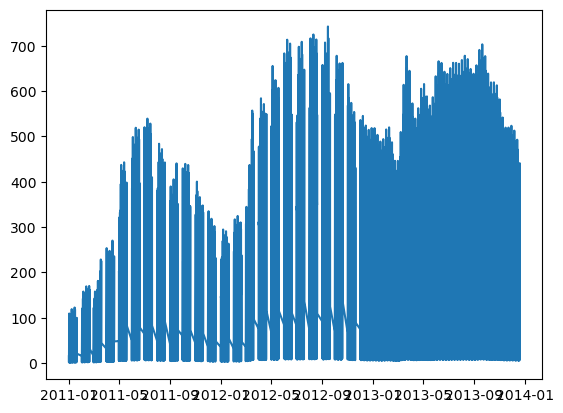

In [2]:
from common import *

df = pd.read_csv('bike_demand.csv')
df.rename(columns={"datetime":"ds", "count":"real_y"}, inplace=True)
df["y"] = np.log(df["real_y"])

m = Prophet(changepoint_prior_scale=0.9895422205291365, changepoint_range=0.657223678519697,
           holidays_prior_scale=32.14468171586942, seasonality_mode="additive",
           seasonality_prior_scale=0.02168372346833077)
m.add_seasonality(name='yearly', period=365, fourier_order=10)
# m.add_regressor('weather')
# m.add_regressor('atemp')
# m.add_regressor('humidity')
# m.add_regressor('workingday')
# m.add_regressor('temp')
m.fit(df)
future = m.make_future_dataframe(periods=24*365, freq='H')
forecast = m.predict(future)

logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
mae = np.abs(np.exp(df_cv["yhat"]) - np.exp(df_cv["y"])).mean()

print("Mean MAE:", str(mae))

plt.plot(forecast['ds'], np.exp(forecast['yhat']))